# Control

Control: Provides deterministic decision-making and process flow control.
This component handles if/then logic, routing based on conditions, and process orchestration for predictable behavior.

## Control flow using Gemini API
Same can be done using Groq API

In [37]:
from google import genai
from google.genai import types
from typing import Optional, Literal
from dotenv import load_dotenv
import os

load_dotenv()

True

In [25]:
from pydantic import BaseModel, Field
import json

class IntentClassification(BaseModel):
    intent: Literal['question', 'request', 'complaint'] = Field(description="Intent of the query.")
    confidence: float = Field(description="confidence level of making classification, float value between 0 and 1.0")
    reasoning: str = Field(description="Reason why the query is one of the intents.")

def route_based_on_intent(user_query: str) -> tuple[str, IntentClassification]:
    client = genai.Client()
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[
            ("system", "lassify user input into one of three categories: question, request, or complaint. Provide your reasoning and confidence level."),
            ("user", user_query),
        ],
        config= types.GenerateContentConfig(
            response_mime_type="application/json",
            response_schema=IntentClassification
        )
    )
    classification = json.loads(response.text)
    intent = classification['intent']
    
    if intent=="question":
        result = answer_question(user_query)
    elif intent=="request":
        result = process_request(user_query)
    elif intent=="complaint":
        result = handle_complaint(user_query)
    else:
        result = "I'm not sure how to help with that."
        
    return result, classification

def answer_question(user_query: str)-> str:
    client = genai.Client()
    response = client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=f"Answer this question: {user_query}",
    )
    return response.text

def process_request(user_query: str)-> str:
    return f"Your request is being processed: {user_query}"

def handle_complaint(user_query: str) -> str:
    client = genai.Client()
    response = client.models.generate_content(
        model="gemini-2.0-flash-lite",
        contents=[
            ("system", """You deal with the complaints, respond in a empathetic and concise way and always appologize for bad experience and tell them that we will work on improvements based on their feedback.
             """),
            ("user", user_query)
        ]
    )
    return response.text

In [26]:
response, classification = route_based_on_intent(user_query="I'm unhappy with the service quality")
response

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


"I am so sorry to hear that you're unhappy with the service quality. I sincerely apologize for the negative experience you had. We appreciate your feedback and will use it to work on improvements.\n"

In [27]:
response, classification = route_based_on_intent(user_query="What is machine learning?")
response

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


'Machine learning (ML) is a branch of artificial intelligence (AI) that focuses on enabling computers to learn from data without being explicitly programmed. Instead of being given specific instructions to perform a task, machine learning algorithms are trained on a dataset, allowing them to identify patterns, make predictions, and improve their performance over time.\n\nHere\'s a breakdown of key aspects:\n\n*   **Learning from Data:** The core principle of ML is that algorithms learn by analyzing data. This data can be anything from images and text to numbers and financial transactions.\n*   **Algorithms:** ML utilizes various algorithms, such as decision trees, support vector machines, neural networks, and more. These algorithms are the "brains" of the system, analyzing the data and making decisions.\n*   **Patterns and Predictions:** The goal of ML is often to find patterns in data and use those patterns to make predictions or classifications about new, unseen data.\n*   **Improvem

In [28]:
response, classification = route_based_on_intent(user_query="Please schedule a meeting for tomorrow")
response

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


'Your request is being processed: Please schedule a meeting for tomorrow'

## LangChain: Control Flow using LangGraph

In [30]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model

In [31]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)
llm = init_chat_model(model="gemini-2.0-flash", model_provider="google_genai")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

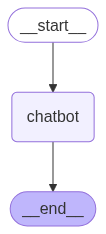

In [33]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Unable to load the graph image.")

In [35]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
while True:
    try:
        user_input = input("user: ")
        if user_input.lower() in ["quit", "bye", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except Exception:
        user_input = "What do you know about langgraph?"
        print("user: "+ user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi Aaditya, it's nice to meet you! How can I help you today?
Assistant: LLMs (Large Language Models) learn by ingesting massive amounts of text data. They use a neural network architecture called a transformer, which excels at understanding relationships between words in a sequence. During training, the model predicts the next word in a sentence, adjusting its internal parameters to minimize prediction errors. This process allows the LLM to learn patterns, grammar, and even some world knowledge. After training, the model can generate text, translate languages, and answer questions based on its learned knowledge, all by predicting the most probable sequence of words.
Assistant: I'm sorry, but I don't have access to your past conversations, so I can't recall what your last question was.
Assistant: As a large language model, I have no memory of past conversations. Therefore, I do not know your name. You have not told me your name.
Goodbye!


In [38]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What is a `node` in langgraph?")

{'query': 'What is a `node` in langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
   'title': "Beginner's Guide to LangGraph: Understanding State, Nodes, and ...",
   'content': 'Nodes: Nodes are the fundamental building blocks of a graph. Each node represents a specific function or operation that processes the current',
   'score': 0.83710164,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'content': '*   **Stateful Graph:** LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges,

In [39]:
llm_with_tools = llm.bind_tools(tools)

In [53]:
from langgraph.prebuilt.tool_node import ToolNode
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [54]:
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No message found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

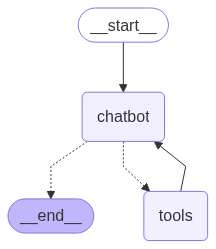

In [55]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print("Unable to load the graph image.")

In [56]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except Exception:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today?
Assistant: 
Assistant: {"query": "today's date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.inchcalculator.com/what-is-todays-date/", "title": "What Is Today's Date? - Inch Calculator", "content": "Today, August 2nd , is day 214 of 365 total days in 2025. What is Today's Date in Numbers? Today's date in numbers is: MM-DD-YYYY: 08-02-2025; DD-MM-YYYY:", "score": 0.829285, "raw_content": null}, {"url": "https://www.rapidtables.com/tools/todays-date.html", "title": "Today's Date | Current date now - RapidTables.com", "content": "This page includes the following information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds.", "score": 0.7598145, "raw_content": null}], "response_time": 2.73}
Assistant: Today is August 2nd, 2025.
Assistant: 
Assistant: {"query": "current date in India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "h